# AI Summit 2019 Workshop - RecSys ML and DNN
-- [ 전용준. YONG. Yong Xune Xon. 리비젼컨설팅. revisionconsulting. revision.co.kr. xyxonxyxon@empal.com ]
- clustering
- collaborative filtering
- deep learning

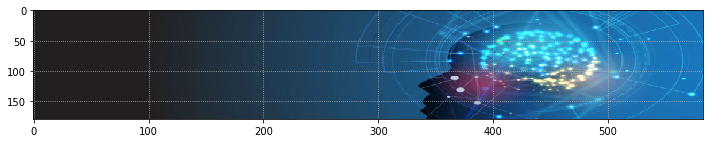

In [191]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('http://cfile209.uf.daum.net/image/99F55F335DDB5F4112D958') 
  
# Output Images 
plt.figure(figsize=(12,2))
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.show()


In [243]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.style as style 
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')


# to set github url as data path
dataPath = 'https://github.com/stillxyxon/aisummitRecSys/raw/master/'

# define universally useful UDFs

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


def rjitt2(arr):
    stdev = .031*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

# custom one-hot encoder
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

## 1. Dataset Loading
- A publicly availble dataset of B2B online retailer
- Data source : https://archive.ics.uci.edu/ml/datasets/online+retail 
- Most of the customers are wholesalers in Europe

In [244]:
# load dataset

# tr01a = tr01.head(270955)
# tr01a.to_csv(dataPath + 'onlneRetail_A.csv', index=False)
print(dataPath + 'onlneRetail_A.csv')

tr01a = pd.read_csv(dataPath + 'onlneRetail_A.csv')

# tr01b = tr01.tail(270954)
# tr01b.to_csv(dataPath + 'onlneRetail_B.csv', index=False)
tr01b = pd.read_csv(dataPath + 'onlneRetail_B.csv')

# to bypass github upload size limitation, read pre-split datasets and merge
tr01 = pd.concat([tr01a, tr01b], axis=0)
print(tr01.shape)


SCdesc_mast = tr01[['StockCode','Description']].drop_duplicates()

print(len(tr01.CustomerID.unique()))
tr01.head()

https://github.com/stillxyxon/aisummitRecSys/raw/master/onlneRetail_A.csv
(541909, 8)
4373


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom


In [217]:
# get list of unique customers

ucusts = list(tr01.CustomerID.unique().astype(int))

import random 

random.sample(ucusts, 100)[:5]

[17549, 16395, 18158, 14477, 12910]

### 2. EDA to design and scope the recsys
- Get frequency for each StockCode (=Item)

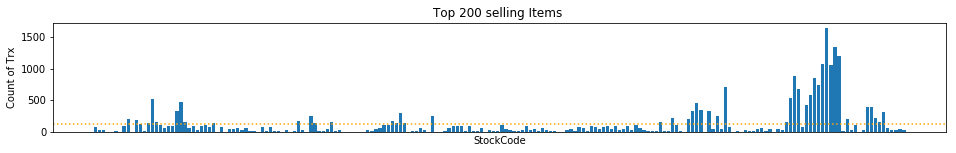

61514


,StockCode,InvoiceNo
3536,85123A,2313
1348,22423,2203
3515,85099B,2159
2733,47566,1727
180,20725,1639


In [10]:
df101 = tr01[['InvoiceNo', 'StockCode']].groupby('StockCode').count().reset_index()

plt.figure(figsize=(16,2))
plt.bar(df101.head(200).StockCode, df101.head(200).InvoiceNo)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.axhline(df101.head(200).InvoiceNo.mean(), color='orange', linestyle=':')
plt.title('Top 200 selling Items ')
plt.ylabel('Count of Trx')
plt.xlabel('StockCode')
plt.show()

nitm = 50
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)
print(df101.InvoiceNo.sum())
df101.head()

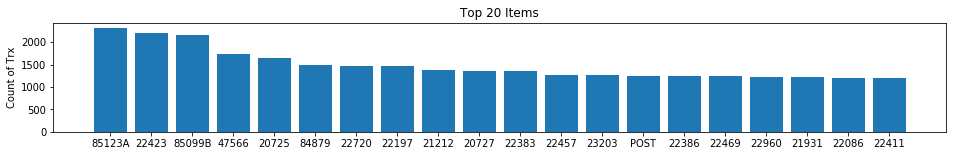

In [11]:
plt.figure(figsize=(16,2))
plt.bar(df101.StockCode[:20], df101.InvoiceNo[:20])
plt.title('Top 20 Items')
plt.ylabel('Count of Trx')
plt.show()

- <font color='blue'>Notice that POST is not an item appropriate to be recommended</font>. That's why we need EDA before getting into the main job.

In [12]:
trxdtlcnt = tr01.shape[0]
trxdtlcnt_top20 = tr01[tr01.StockCode.isin(df101.StockCode)].shape[0]
print(trxdtlcnt_top20, trxdtlcnt, '\nTop ', nitm,' items account for ',
      round(trxdtlcnt_top20/trxdtlcnt*100,2), '% of total count of transaction detail')

61514 541909 
Top  50  items account for  11.35 % of total count of transaction detail


- [참고] 전체 건수에서 Top 10 items 차지하는 건수 비중이 크지 않지만 단순화하기 위해 여기서는 Top 20~50으로 한정해서
- 실전에서라면 적어도 20~50% coverage 수준의 items을 적용해야 할 것. item 선정하기 위한 추가 작업도 필요

In [14]:
ustockcodes = list(tr01.StockCode.unique())
print(len(ustockcodes))

4070


- 4070개 stockcode 중 Top 500개를 선정하는 경우 51.04% 정도의 trx cnt를 커버할 수 있음

In [15]:
select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top 20 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]
print(tr02.shape)
tr02.head()
print(tr02.CustomerID.unique().shape)

['85123A', '22423', '85099B', '47566', '20725', '84879', '22720', '22197', '21212', '20727', '22383', '22457', '23203', 'POST', '22386', '22469', '22960', '21931', '22086', '22411', '20728', '22382', '22961', '22666', '23298', '22699', '22384', '23209', '82482', '22993', '22727', '22697', '23206', '22178', '20724', '23084', '20726', '22726', '21080', '23199', '22139', '22077', '22138', '21034', '22470', '85099C', '84946', '21790', '82494L', '20914']
50
(61514, 8)
(3770,)


# 3. Clustering 
- Clustering Users to make recommendations

- K-Prototype Algorithm for Clustering Mixed attributes - combining k-means and k-modes
- k-modes clustering for categorical data. The mode of a set of data values is the value that appears most often.

In [99]:
# Use only Top 20 items for simplicity

nitm = 20
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)

select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top 20 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]
tr02.head()

['85123A', '22423', '85099B', '47566', '20725', '84879', '22720', '22197', '21212', '20727', '22383', '22457', '23203', 'POST', '22386', '22469', '22960', '21931', '22086', '22411']
20


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 8:34,1.69,13047.0,United Kingdom
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 8:34,4.25,13047.0,United Kingdom
45,536370,POST,POSTAGE,3,2010-12-01 8:45,18.00,12583.0,France
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 9:00,2.55,13748.0,United Kingdom


In [100]:
# 고객별 stockcode별 invoice count 집계 

tr03 = tr02[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr03.shape)
tr03.head()

# pivoting to make long format table to wide format table 

tr04c = tr03.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr04c.fillna(0, inplace=True)
print(tr04c.shape)
tr04c.head()

(11193, 3)
(3265, 21)


StockCode,CustomerID,20725,20727,21212,21931,22086,22197,22383,22386,22411,...,22457,22469,22720,22960,23203,47566,84879,85099B,85123A,POST
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [194]:
# to create a categorical feature - Most frequent country

idx = tr02[['InvoiceNo','CustomerID','Country']].groupby(['CustomerID','Country'])['InvoiceNo'].transform(max) == tr02['InvoiceNo']
tr04cc = tr02[idx].reset_index()[['CustomerID', 'Country']]
tr04cc.head()


,CustomerID,Country
0,18074.0,United Kingdom
1,18074.0,United Kingdom
2,16250.0,United Kingdom
3,12791.0,Netherlands
4,17908.0,United Kingdom


In [200]:
# 주로 거래건이 발생되는 country의 분포 (고객별)
tr04cc.Country.value_counts().reset_index().head(10)

,index,Country
0,United Kingdom,5099
1,France,132
2,Germany,119
3,Spain,52
4,Belgium,46
5,Portugal,38
6,Switzerland,33
7,Italy,29
8,Finland,21
9,Channel Islands,20


In [102]:
# merge categorical feature 'Country'

tr04c = tr04c.merge(tr04cc, how='left', on='CustomerID')
# fill NAs
tr04c['Country'].fillna('NA', inplace=True)
tr04c.head()

,CustomerID,20725,20727,21212,21931,22086,22197,22383,22386,22411,...,22469,22720,22960,23203,47566,84879,85099B,85123A,POST,Country
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland
1,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,Finland
2,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Italy
3,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Italy
4,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Italy


In [103]:
#  https://medium.com/datadriveninvestor/k-prototype-in-clustering-mixed-attributes-e6907db91914

from kmodes.kprototypes import KPrototypes

dfkprt = tr04c.ix[:,:22]

kproto = KPrototypes(n_clusters=10, verbose=0)

X = np.array(dfkprt)
clusters = kproto.fit_predict(X, categorical=[21])

# Print cluster centroids of the trained model.
# print(kproto.cluster_centroids_)
# Print training statistics
# print(kproto.cost_)
print(kproto.n_iter_)

dfkprt['clst'] = clusters
dfkprt.head()

34


,CustomerID,20725,20727,21212,21931,22086,22197,22383,22386,22411,...,22720,22960,23203,47566,84879,85099B,85123A,POST,Country,clst
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland,1
1,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,Finland,1
2,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Italy,1
3,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Italy,1
4,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Italy,1


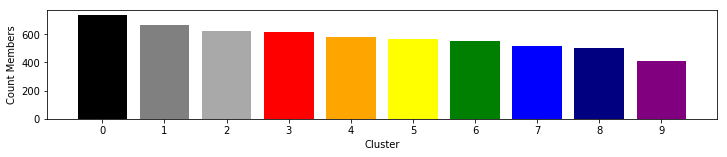

In [146]:
# check distribution of frequency (num of members) in each cluster

colist = ['black', 'grey', 'darkgrey', 'red', 'orange', 
          'yellow', 'green', 'blue', 'navy', 'purple']            

plt.figure(figsize=(12,2))
plt.bar(np.array(range(10)).astype(str), dfkprt['clst'].value_counts(),
       color = colist)
plt.xlabel('Cluster')
plt.ylabel('Count Members')
plt.show()

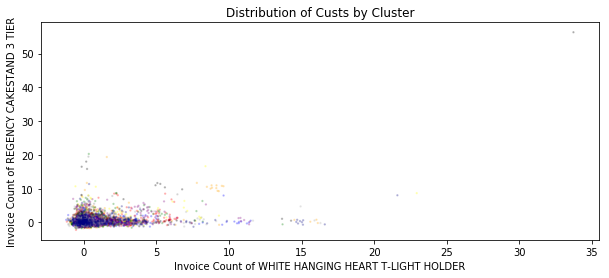

In [148]:
colors1 = [colist[x] for x in clusters]

plt.figure(figsize=(10,4))
plt.scatter(rjitt(dfkprt['85123A']), rjitt(dfkprt['22423']),
            color=colors1, alpha=0.2, s=2)
plt.title('Distribution of Custs by Cluster')
plt.xlabel('Invoice Count of WHITE HANGING HEART T-LIGHT HOLDER')
plt.ylabel('Invoice Count of REGENCY CAKESTAND 3 TIER')    
plt.show()

- 2 top selling items 을 기준으로 scatter plot에서 cluster가 혼재하는 양상을 보인다는 것은?
- 2 top selling items 만으로는 극히 일부분 밖에는 설명할 수 없다는 의미
- Cluster 특징 profiling을 위해 DT, Catboost (Var Importance) 활용 가능

In [202]:
# Profile Clusters : Most popular items in each cluster

for x in range(3):
    mems = dfkprt[dfkprt.clst ==x]['CustomerID']
    tr02tmp = tr02[tr02.CustomerID.isin(mems)][['InvoiceNo','Description']].groupby(['Description']).count().reset_index()
    print('\nSegment', x , '.............\n')
    print(tr02tmp.sort_values('InvoiceNo', ascending=False).head(7))


Segment 0 .............

                           Description  InvoiceNo
20            REGENCY CAKESTAND 3 TIER        272
23  WHITE HANGING HEART T-LIGHT HOLDER        202
5              JUMBO BAG RED RETROSPOT        161
0        ASSORTED COLOUR BIRD ORNAMENT        159
21   SET OF 3 CAKE TINS PANTRY DESIGN         144
2             JAM MAKING SET WITH JARS        143
14     NATURAL SLATE HEART CHALKBOARD         142

Segment 1 .............

                          Description  InvoiceNo
18                            POSTAGE       1053
19           REGENCY CAKESTAND 3 TIER        279
10            LUNCH BAG RED RETROSPOT        183
5             JUMBO BAG RED RETROSPOT        172
14    PACK OF 72 RETROSPOT CAKE CASES        170
20  SET OF 3 CAKE TINS PANTRY DESIGN         137
2            JAM MAKING SET WITH JARS        123

Segment 2 .............

                           Description  InvoiceNo
23  WHITE HANGING HEART T-LIGHT HOLDER        209
17                       PARTY

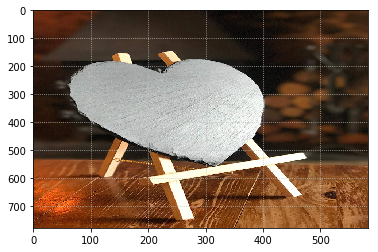

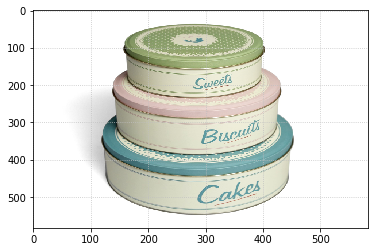

In [210]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# NATURAL SLATE HEART CHALKBOARD
img = mpimg.imread('http://cfile215.uf.daum.net/image/99084B505DDCB8B31138D8') 
  
# Output Images 
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.show()

# SET OF 3 CAKE TINS PANTRY DESIGN    
img = mpimg.imread('http://cfile230.uf.daum.net/image/99AA6E505DDCB8BA086839') 
  
# Output Images 
plt.imshow(img, aspect='auto') 
plt.grid(linestyle=':', color='silver')
plt.show()

- cluster별로 top selling items 구성이 다르다는 것은 cluster를 기준으로 상품 추천시 고객별로 서로 다른 item이 추천될 수 있다는 의미
- customer를 cluster 할 것인가 item을 cluster 할 것인가?

# 4. Collaborative Filtering
- Impementing Item based Fitering

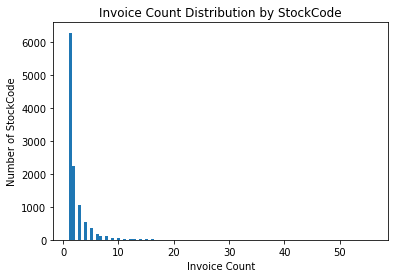

,StockCode,CustomerID,InvoiceCnt
0,20725,12354.0,1
1,20725,12361.0,1
2,20725,12362.0,2
3,20725,12371.0,1
4,20725,12378.0,1


In [153]:
# create item-user matrix 
# tr02.head()

itmusr_mtrx =  tr02[['InvoiceNo', 'StockCode', 'CustomerID']].groupby(['StockCode','CustomerID']).count().reset_index()
itmusr_mtrx.columns = ['StockCode', 'CustomerID', 'InvoiceCnt']

plt.hist(itmusr_mtrx.InvoiceCnt, bins=100) 
plt.title('Invoice Count Distribution by StockCode')
plt.xlabel('Invoice Count')
plt.ylabel('Number of StockCode')
plt.show()

itmusr_mtrx.head()

- 20개 item간의 관계만을 사용해서 CF (for simlicity)
- item 수는 대폭 increase 필요
- Invoice Count 대신 Invoice 여부를 사용할 수도 다른 metric을 설계할 수도 있음

3265  customers
iteration .....  1
iteration .....  2
iteration .....  3
iteration .....  4
iteration .....  5
iteration .....  6
iteration .....  7
iteration .....  8
iteration .....  9
iteration .....  10
iteration .....  11
iteration .....  12
iteration .....  13
iteration .....  14
iteration .....  15
iteration .....  16
iteration .....  17
iteration .....  18
iteration .....  19
iteration .....  20


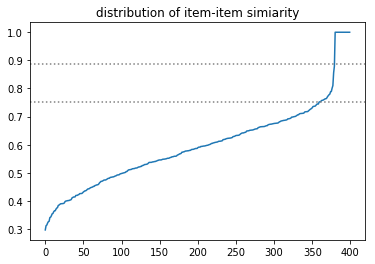

In [154]:
# create item-item matrix

custs = itmusr_mtrx.CustomerID.unique()
print(len(custs), ' customers')

scs = itmusr_mtrx.StockCode.unique()
nscs = len(scs)
# create an empty matrix
w, h = 3, (nscs*nscs)
itmitm_mtrx = np.array([[None for x in range(w)] for y in range(h)])

seqi= 0
for i in scs:
    seqj = 0
    for j in scs:
        # print(i, j, type(i))
        tmpcustsi = itmusr_mtrx[itmusr_mtrx.StockCode ==i]['CustomerID'].unique()
        tmpcustsj = itmusr_mtrx[itmusr_mtrx.StockCode ==j]['CustomerID'].unique()
        # print(len(tmpcustsi), len(tmpcustsj))

        # print([seqi, seqj, len(set(tmpcustsi) & set(tmpcustsi)) , list(set().union(tmpcustsi, tmpcustsj))])
        
        # 비교대상이 되는 두 고객집단 (item i를 구매한 고객리스트와 j를 구매한 고객리스트) 간의 
        # 교집합 고객수를 합집합 고객수로 나눈 값으로 simiarity 측정
        itmitm_mtrx[(seqi*nscs) + seqj] = [i, j, len(set(tmpcustsi) & set(tmpcustsi)) / len(set().union(tmpcustsi, tmpcustsj))]
        if seqj<nscs:
            seqj = seqj + 1
            
    if seqi<nscs:        
        seqi = seqi + 1    
    print('iteration ..... ', seqi) 
        

itmitm_mtrx = pd.DataFrame(itmitm_mtrx)
itmitm_mtrx.columns =['StockCode','SCj','simScr']

plt.plot(np.sort(itmitm_mtrx.simScr))
plt.title('distribution of item-item simiarity')

# 추천시 사용할 cutoff 를 확인하기 위해
plt.axhline(np.percentile(itmitm_mtrx.simScr,95), linestyle=':', color='grey')
plt.axhline(np.percentile(itmitm_mtrx.simScr,90), linestyle=':', color='grey')
plt.show()

In [211]:
# 합집합은 무시하고 교집합의 크기를 추가적인 가중치 facotr로 사용하는 등 다양한 아이디어 활용 가능

In [212]:
print(itmitm_mtrx.shape)
# 20X20 matrix 이므로 400

itmitm_mtrx.head()
# itmitm_mtrx[itmitm_mtrx.StockCode.isin(['20725','20727'])]

(400, 3)


,StockCode,SCj,simScr
0,20725,20725,1
1,20725,20727,0.771014
2,20725,21212,0.549587
3,20725,21931,0.757835
4,20725,22086,0.529353


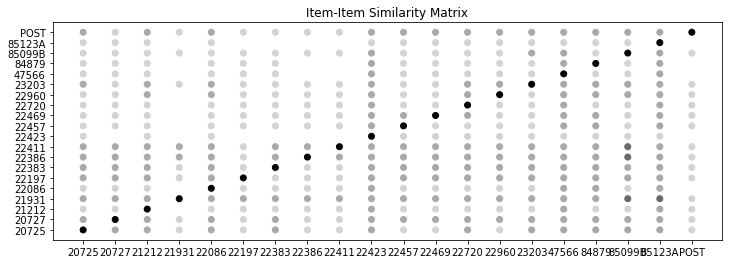

In [179]:
plt.figure(figsize=(12,4)) 
monocolpal = ['black', 'dimgray', 'darkgray', 'lightgrey', 'white']
simScr5 = 5-np.array(itmitm_mtrx.simScr * 5).astype(int)

colors1 = [monocolpal[x] for x in simScr5]
plt.scatter(itmitm_mtrx.StockCode, itmitm_mtrx.SCj, color=colors1)
plt.title('Item-Item Similarity Matrix')
plt.show()

- [ 참고 ] 기준이되는 item을 정한 후 계산하기 때문에 matrix가 대칭이 아님
- Pattern 특성 : Frequency가 높은 item은 다른 item들과의 similarity가 전반적으로 높음 (--> 분산을 위해 의도적 조정 여지 존재)

### recommendation using item-based filtering

In [218]:
# to pick samples 
from random import sample 

smp_custs = np.array(random.sample(list(custs), 10)).astype(int)


# select items to recommend
for i in range(5):
    tmptrx = tr02[tr02.CustomerID == smp_custs[i]][['StockCode', 'CustomerID']].drop_duplicates()
    tmpsimmat01 = itmitm_mtrx[(itmitm_mtrx.simScr>0.6) & (itmitm_mtrx.simScr<1)][itmitm_mtrx.StockCode.isin(tmptrx.StockCode.unique())].drop_duplicates()
    tmpsimmat02 = tmpsimmat01[['SCj','simScr']].groupby('SCj').sum().reset_index()
    tmpsimmat02['simScr'] = tmpsimmat02.simScr / tmpsimmat02.simScr.max()
    dfrecomm = tmpsimmat02.sort_values('simScr', ascending=False).head(3)
    print(i, ' : \n', 
          'Bought : ', np.array(SCdesc_mast[SCdesc_mast.StockCode.isin(tmptrx.StockCode.unique())].Description), '\n\n', 
          'Recommends : ',np.array(SCdesc_mast[SCdesc_mast.StockCode.isin(dfrecomm['SCj'])].Description), '\n', 
          dfrecomm, '\n'
          )
    

0  : 
 Bought :  ['JAM MAKING SET WITH JARS' 'PACK OF 72 RETROSPOT CAKE CASES'
 'JUMBO STORAGE BAG SUKI' 'REGENCY CAKESTAND 3 TIER' 'faulty' 'damages'] 

 Recommends :  ['JUMBO BAG PINK POLKADOT' 'JUMBO STORAGE BAG SUKI'
 'JUMBO SHOPPER VINTAGE RED PAISLEY'] 
      SCj   simScr
7  22386  1.00000
8  22411  0.99534
3  21931  0.79977 

1  : 
 Bought :  ['WHITE HANGING HEART T-LIGHT HOLDER' 'HEART OF WICKER SMALL'
 'PARTY BUNTING' nan '?' 'wrongly marked carton 22804'
 'CREAM HANGING HEART T-LIGHT HOLDER'] 

 Recommends :  ['JUMBO BAG PINK POLKADOT' 'JUMBO STORAGE BAG SUKI'
 'JUMBO SHOPPER VINTAGE RED PAISLEY'] 
      SCj    simScr
3  21931  1.000000
7  22386  0.981630
8  22411  0.970259 

2  : 
 Bought :  ['JUMBO SHOPPER VINTAGE RED PAISLEY'] 

 Recommends :  ['JUMBO BAG PINK POLKADOT' 'JUMBO STORAGE BAG SUKI'] 
      SCj    simScr
0  21931  1.000000
1  22386  0.935811 

3  : 
 Bought :  ["PAPER CHAIN KIT 50'S CHRISTMAS "] 

 Recommends :  ['JUMBO STORAGE BAG SUKI' 'JUMBO SHOPPER VINTAGE 

# 5. DNN-based RecSys

In [16]:
# Use only Top 20 items

nitm = 20
df101 = df101.sort_values(by = 'InvoiceNo', ascending=False).head(nitm)

select_stockcodes = list(df101.StockCode)
print(select_stockcodes)

print(len(select_stockcodes))

# Top 20 해당하는 StockCode만을 포함하는 trx 건 추출
tr02 = tr01[tr01.StockCode.isin(select_stockcodes)]

['85123A', '22423', '85099B', '47566', '20725', '84879', '22720', '22197', '21212', '20727', '22383', '22457', '23203', 'POST', '22386', '22469', '22960', '21931', '22086', '22411']
20


## 5.1. 기간 구분 (partitioning)
- 추천시스템을 과거의 사용자 행동 시그널을 바탕으로 미래의 이용 패턴을 예측하는 방식으로 구성
- 목적에 따른 기간의 구성에 따라 초단기, 단기 등 여러 선택 가능

In [17]:
# Months for X (input feature)
tr021 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-03', '2011-04', '2011-05'])]

# Months for Y (target variable)
tr022 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-06'])]

# tr021.head()
tr022.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
209033,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 7:38,12.75,15643.0,United Kingdom
209036,555157,47566,PARTY BUNTING,8,2011-06-01 7:38,4.95,15643.0,United Kingdom
209070,555158,21931,JUMBO STORAGE BAG SUKI,10,2011-06-01 8:38,2.08,14842.0,United Kingdom
209083,555158,22960,JAM MAKING SET WITH JARS,12,2011-06-01 8:38,3.75,14842.0,United Kingdom
209089,555158,22423,REGENCY CAKESTAND 3 TIER,2,2011-06-01 8:38,12.75,14842.0,United Kingdom


## 5.2. Input and Target Feature 생성 (Aggregation)

In [18]:
tr03 = tr021[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr03.shape)
tr03.head()

(4027, 3)


,CustomerID,StockCode,InvoiceNo
0,12347.0,22423,1
1,12348.0,POST,1
2,12352.0,POST,2
3,12354.0,20725,1
4,12355.0,22423,1


In [19]:
# pivoting to make long format table to wide format table 

tr04 = tr03.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr04.fillna(0, inplace=True)

# add prefix sc (=StockCode)
sc_list = np.char.array(['sc']) + np.array(tr04.columns[1:(nitm+1)])
tr04.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr04.shape)
tr04.head()


(1459, 21)


,CustomerID,sc20725,sc20727,sc21212,sc21931,sc22086,sc22197,sc22383,sc22386,sc22411,...,sc22457,sc22469,sc22720,sc22960,sc23203,sc47566,sc84879,sc85099B,sc85123A,scPOST
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- 10개 top selling items 만을 input feature로 사용했으나 더 많은 feature들을 사용하는 것 가능
- aggregation of item trx count 이외의 성격의 input feature 추가 가능 (e.g. 고객의 규모, 고객의 geo-location, nationality, demographics(B2C 경우) 등)

In [20]:
# target variable 생성해 결합

tr05 = tr022[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr05.shape)

tr06 = tr05.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr06.fillna(0, inplace=True)

# add prefix sct (= Target SC )
sc_list = np.char.array(['sct']) + np.array(tr06.columns[1:(nitm+1)])
tr06.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr06.shape)

tr07 = tr04.merge(tr06, on='CustomerID', how='left')
tr07.fillna(0, inplace=True)
tr07['seqM'] = 1
tr07.head()



(1681, 3)
(668, 21)


,CustomerID,sc20725,sc20727,sc21212,sc21931,sc22086,sc22197,sc22383,sc22386,sc22411,...,sct22469,sct22720,sct22960,sct23203,sct47566,sct84879,sct85099B,sct85123A,sctPOST,seqM
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


- 1개월 기간을 이동시킨 train dataset을 추가로 생성 -- 계절적 차이 영향 완화 및  sample size 증대 효과
- 실제 상황에서는 더 많은 시점을 동시 고려하는 것이 바람직할 수 있음

In [21]:
# Months for train X
tr023 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-04', '2011-05', '2011-06'])]
# Months for train Y
tr024 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-07'])]

tr11 = tr023[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr11.shape)

tr12 = tr11.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr12.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sc']) + np.array(tr12.columns[1:(nitm+1)])
tr12.columns = np.concatenate([np.array(['CustomerID']), sc_list])

tr13 = tr024[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()

tr14 = tr13.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr14.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sct']) + np.array(tr14.columns[1:(nitm+1)])
tr14.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr14.shape)

tr15 = tr12.merge(tr14, on='CustomerID', how='left')
tr15.fillna(0, inplace=True)
tr15['seqM'] = 2
tr15.head()



(3994, 3)
(658, 21)


,CustomerID,sc20725,sc20727,sc21212,sc21931,sc22086,sc22197,sc22383,sc22386,sc22411,...,sct22469,sct22720,sct22960,sct23203,sct47566,sct84879,sct85099B,sct85123A,sctPOST,seqM
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,12356.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [22]:
# 서로 다른 두 개 시점을 기준으로 생성한 set을 통합해 train set 완성

tr071 = pd.concat([tr07, tr15], axis=0)
print(tr071.shape)
tr071.head()

(2900, 42)


,CustomerID,sc20725,sc20727,sc21212,sc21931,sc22086,sc22197,sc22383,sc22386,sc22411,...,sct22469,sct22720,sct22960,sct23203,sct47566,sct84879,sct85099B,sct85123A,sctPOST,seqM
0,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,12354.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [220]:
# X set 과 Y set 분리 

X_train = tr071.ix[:,1:(nitm+1)]
y_train = tr071.ix[:,(nitm+1):((2*nitm)+1)]

X_train.head()

,sc20725,sc20727,sc21212,sc21931,sc22086,sc22197,sc22383,sc22386,sc22411,sc22423,sc22457,sc22469,sc22720,sc22960,sc23203,sc47566,sc84879,sc85099B,sc85123A,scPOST
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_train.head()

,sct20725,sct20727,sct21212,sct21931,sct22086,sct22197,sct22383,sct22386,sct22411,sct22423,sct22457,sct22469,sct22720,sct22960,sct23203,sct47566,sct84879,sct85099B,sct85123A,sctPOST
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
# EDA on the relationship between variables 

# to check correlations between Xs and Ys

tmparr = np.array([]).astype(float)

for x in range(nitm):
    tmparr = np.append(tmparr, np.corrcoef(X_train.ix[:,x], y_train.ix[:,x])[0,1])
print(tmparr)    
print(tmparr.mean())

[ 0.4944019   0.46653172  0.22404992  0.43356669 -0.00495182  0.54738832
  0.44215981  0.45752318  0.44071105  0.39463858  0.26396266  0.15617091
  0.31310585  0.23514914  0.35797473  0.41849287  0.39900591  0.47691493
  0.41113849  0.55741817]
0.37426765074225166


- 동일 상품을 반복해서 (=서로 다른 기간에도) 구매하는 패턴이 상당함을 확인
- 단, 상품별로 차이 존재 (= 구매주기의 차이일 가능성 존재)

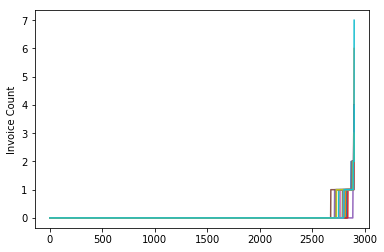

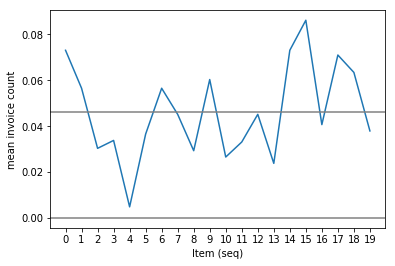

In [227]:
# check distibution of the target variables 

means = np.array([]).astype(int)
means
for x in range(0,nitm):
    plt.plot(np.sort(y_train.ix[:,x]))
    means = np.append(means, y_train.ix[:,x].mean())
plt.ylabel('Invoice Count')    
plt.show()    

plt.plot(np.array(range(0,nitm)).astype(str), means)
plt.axhline(means.mean(), color='grey')
plt.axhline(0, color='grey')
plt.xlabel('Item (seq)')
plt.ylabel('mean invoice count')
plt.show()

- Target (예측대상 품목별 이용 결과) 변수의 형식을 구매여부, 구매금액, 구매빈도 등 다양한 방식으로 정의할 수 있음
- 추천서비스의 궁극적 목표에 따라 다른 설계 필요

In [24]:
# to binarize 
# 10개 item의 구매여부를 classification 문제 형식으로 정의

# for x in range(nitm):
#     y_train.ix[:,x] = np.where(y_train.ix[:,x]>0,1,0) # Target
#     X_train.ix[:,x] = np.where(X_train.ix[:,x]>0,1,0) # inputs

In [27]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의
# to quantile-based normalized inputs (c.f. YouTube 2016)

from scipy.stats import percentileofscore

# X1_tmp = X_train.ix[:,1].copy()
# arr_sorted =  sorted(np.array(X_train.ix[:,1].copy()))
# s = X_train.ix[:,1]
# X1_tmp_qn = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs

# plt.scatter(X1_tmp, X1_tmp_qn)
# plt.xlabel('original')
# plt.ylabel('quantile normalized')
# plt.show()

for x in range(nitm):
    y_train.ix[:,x] = np.where(y_train.ix[:,x]>0,1,0) # Target
    
    arr_sorted =  sorted(np.array(X_train.ix[:,x].copy()))
    s = X_train.ix[:,x]
    X_train.ix[:,x] = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs

- 구매여부 대신 구매건수를 타겟으로 설정하는 것도 대안
- c.f. YouTube는 시청시간이 메인타겟
- 여기서는 input feature를 건수 형식으로 정의 (단, 분포 변환 실시)

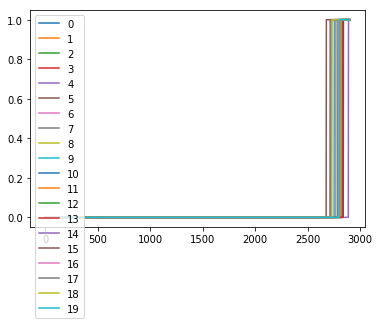

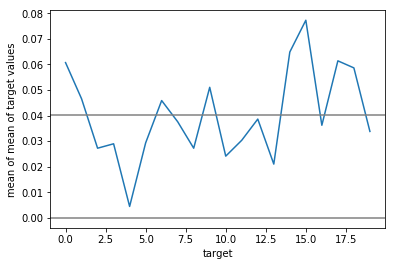

In [28]:
means = np.array([]).astype(int)
means
for x in range(nitm):
    plt.plot(np.sort(y_train.ix[:,x]))
    means = np.append(means, y_train.ix[:,x].mean())
plt.legend(list(range(nitm)), loc='upper left')
plt.show()    

plt.plot(range(0,nitm), means)
plt.axhline(means.mean(), color='grey')
plt.axhline(0, color='grey')
plt.xlabel('target')
plt.ylabel('mean of mean of target values')
plt.show()

In [29]:
tmparr = np.array([]).astype(float)

for x in range(nitm):
    tmparr = np.append(tmparr, np.corrcoef(X_train.ix[:,x], y_train.ix[:,x])[0,1])
print(tmparr) 
print('\nmean of corr = ' , tmparr.mean(), ' # 구매건수간의 상관관계에 비해 변환 후 상관관계 약간 감소')

y_train.head()

[ 0.38595013  0.33620776  0.16484001  0.34525135 -0.00530318  0.4058226
  0.34088908  0.36508514  0.35587502  0.26082546  0.18394536  0.16869833
  0.24769085  0.19966893  0.33537822  0.33403679  0.32590197  0.39669348
  0.34212057  0.50330845]

mean of corr =  0.29964431431171745  # 구매건수간의 상관관계에 비해 변환 후 상관관계 약간 감소


,sct20725,sct20727,sct21212,sct21931,sct22086,sct22197,sct22383,sct22386,sct22411,sct22423,sct22457,sct22469,sct22720,sct22960,sct23203,sct47566,sct84879,sct85099B,sct85123A,sctPOST
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
y_train.columns[:nitm]

Index(['sct20725', 'sct20727', 'sct21212', 'sct21931', 'sct22086', 'sct22197',
       'sct22383', 'sct22386', 'sct22411', 'sct22423', 'sct22457', 'sct22469',
       'sct22720', 'sct22960', 'sct23203', 'sct47566', 'sct84879', 'sct85099B',
       'sct85123A', 'sctPOST'],
      dtype='object')

In [31]:
# check distribution stats

print('mean : \n', X_train.mean(axis=0), '\n\nStdev : \n', X_train.std(axis=0))
print('\nmean : \n',y_train.mean(axis=0), '\n\nStdev : \n', y_train.std(axis=0),)

# Y 기간은 1개월이기 때문에 correlation 상대적으로 낮음 - fluctuaton
# Classification 형태로 구성하려고 하지만 class imbalance 상당히 존재 = rare event prediction 
# Y 기간이 더 짧아진다면(예: 1일) 그 만큼 imbalance 는 더 커질 것

print('\n평균 target event 비율 : ', y_train.mean(axis=0).mean())

mean : 
 sc20725     0.141842
sc20727     0.107176
sc21212     0.145385
sc21931     0.081432
sc22086     0.006173
sc22197     0.093838
sc22383     0.120752
sc22386     0.091507
sc22411     0.082305
sc22423     0.203902
sc22457     0.116463
sc22469     0.074441
sc22720     0.084912
sc22960     0.114809
sc23203     0.108856
sc47566     0.205100
sc84879     0.154901
sc85099B    0.147647
sc85123A    0.202312
scPOST      0.094911
dtype: float64 

Stdev : 
 sc20725     0.320050
sc20727     0.290754
sc21212     0.322006
sc21931     0.261413
sc22086     0.078122
sc22197     0.276600
sc22383     0.303504
sc22386     0.273821
sc22411     0.262521
sc22423     0.350372
sc22457     0.299373
sc22469     0.251983
sc22720     0.265752
sc22960     0.297958
sc23203     0.292336
sc47566     0.351102
sc84879     0.328423
sc85099B    0.323880
sc85123A    0.350209
scPOST      0.277816
dtype: float64

mean : 
 sct20725     0.060690
sct20727     0.046552
sct21212     0.027241
sct21931     0.028966
sct22086   

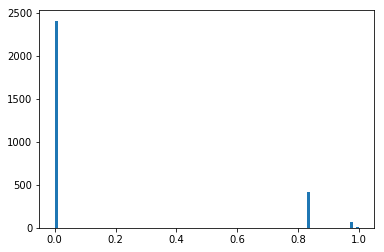

,sc20725,sc20727,sc21212,sc21931,sc22086,sc22197,sc22383,sc22386,sc22411,sc22423,sc22457,sc22469,sc22720,sc22960,sc23203,sc47566,sc84879,sc85099B,sc85123A,scPOST
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.753779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.870746
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.951920
3,0.816997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.753779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [32]:
plt.hist(X_train.ix[:,2], bins=100)
plt.show()

X_train.head()


- YouTube(2016) 사용한 방식의 mimic으로 add super and sub linear derivatives of input features

In [33]:
# add super and sub linear derivatives of input features

# squared as super-linear
X_train_supl = X_train.apply(lambda x: x*x)
X_train_supl.columns = np.char.array(['sup']) + np.array(X_train_supl.columns)

# sqrt as sub-linear
X_train_subl = X_train.apply(lambda x: np.sqrt(x))
X_train_subl.columns = np.char.array(['sub']) + np.array(X_train_subl.columns)

X_train = pd.concat([X_train, X_train_supl, X_train_subl], axis=1)
X_train.shape

(2900, 60)

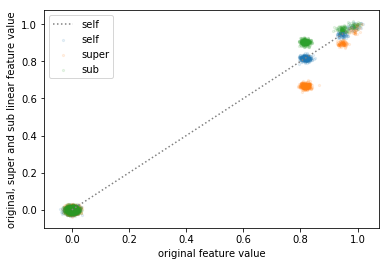

In [43]:
# compare distributions of orginal, super and sub features

plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.sc20725), alpha=0.1, s=5)
plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.supsc20725), alpha=0.1, s=5)
plt.scatter(rjitt(X_train.sc20725), rjitt(X_train.subsc20725), alpha=0.1, s=5)
plt.plot(np.array(range(100))/100, np.array(range(100))/100, color='grey', linestyle=':')
plt.xlabel('original feature value')
plt.ylabel('original, super and sub linear feature value')
plt.legend(['self','self','super', 'sub'])
plt.show()

- original X 가 이미 0~1 scale 된 상태였기에 super, sub 모두 0~1 range에 속함

In [45]:
X_train.head()

,sc20725,sc20727,sc21212,sc21931,sc22086,sc22197,sc22383,sc22386,sc22411,sc22423,...,subsc22457,subsc22469,subsc22720,subsc22960,subsc23203,subsc47566,subsc84879,subsc85099B,subsc85123A,subscPOST
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.753779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.933138
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.975664
3,0.816997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.753779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


- 하나의 Target 변수가 있는 경우와 Extreme multiclass classification 상황은 다름
- 각 Target별로 동일 문제 space의 서로 다른 영역에서 target event가 발생되므로 Class imbalance에 대처하기 위한 수단이 제한적일 수 밖에 없음

## 5.3. DNN Model Buidling

In [84]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout

np.random.seed(23)

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(nitm*3, activation='relu', input_shape=(nitm*3,)))

num_layers = 3
nnode = 128

for _ in range(num_layers):
    # Add hidden layer   
    model.add(Dense(nnode,  activation='relu')) # activation = ['sigmoid', 'relu']
    model.add(Dropout(0.5))
    nnode = int(nnode/2)


# Add an output layer 
model.add(Dense(nitm,  activation='relu'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_32 (Dense)             (None, 128)               7808      
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
__________

In [85]:
# fitting (training) DNN

import datetime
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

start_time = datetime.datetime.now()
print('start : ', start_time )
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    verbose=1, validation_split=0.2, shuffle=True)

end_time = datetime.datetime.now()
print('end : ', end_time )
print('runtime : ', end_time - start_time)
model.summary()

start :  2019-11-26 12:20:23.451739
Train on 2320 samples, validate on 580 samples
Epoch 1/100
2320/2320 [==============================] - 3s 1ms/step - loss: 0.4555 - acc: 0.9589 - val_loss: 0.5195 - val_acc: 0.9556
Epoch 2/100
2320/2320 [==============================] - 1s 333us/step - loss: 0.4252 - acc: 0.9602 - val_loss: 0.4268 - val_acc: 0.9556
Epoch 3/100
2320/2320 [==============================] - 1s 324us/step - loss: 0.3887 - acc: 0.9603 - val_loss: 0.3430 - val_acc: 0.9556
Epoch 4/100
2320/2320 [==============================] - 1s 349us/step - loss: 0.3675 - acc: 0.9591 - val_loss: 0.3306 - val_acc: 0.9556
Epoch 5/100
2320/2320 [==============================] - 1s 310us/step - loss: 0.3117 - acc: 0.9604 - val_loss: 0.2476 - val_acc: 0.9556
Epoch 6/100
2320/2320 [==============================] - 1s 334us/step - loss: 0.2935 - acc: 0.9594 - val_loss: 0.2360 - val_acc: 0.9556
Epoch 7/100
2320/2320 [==============================] - 1s 314us/step - loss: 0.2701 - acc: 0.95

Epoch 60/100
2320/2320 [==============================] - 1s 307us/step - loss: 0.1578 - acc: 0.9606 - val_loss: 0.1644 - val_acc: 0.9556
Epoch 61/100
2320/2320 [==============================] - 1s 312us/step - loss: 0.1555 - acc: 0.9605 - val_loss: 0.1675 - val_acc: 0.9556
Epoch 62/100
2320/2320 [==============================] - 1s 307us/step - loss: 0.1546 - acc: 0.9609 - val_loss: 0.1635 - val_acc: 0.9556
Epoch 63/100
2320/2320 [==============================] - 1s 307us/step - loss: 0.1570 - acc: 0.9607 - val_loss: 0.1647 - val_acc: 0.9556
Epoch 64/100
2320/2320 [==============================] - 1s 304us/step - loss: 0.1564 - acc: 0.9612 - val_loss: 0.1649 - val_acc: 0.9556
Epoch 65/100
2320/2320 [==============================] - 1s 312us/step - loss: 0.1550 - acc: 0.9609 - val_loss: 0.1642 - val_acc: 0.9556
Epoch 66/100
2320/2320 [==============================] - 1s 314us/step - loss: 0.1526 - acc: 0.9607 - val_loss: 0.1662 - val_acc: 0.9556
Epoch 67/100
2320/2320 [==========

## 5.4. Modeling Result Assessment

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])


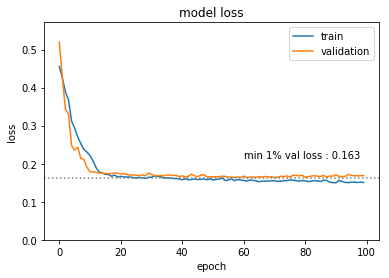

(2900, 20)


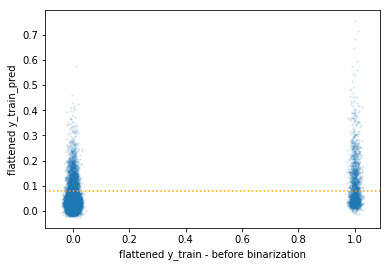

mae =  0.06889769473341936
corr =  0.3376967795438262
r_sqrd =  0.08716


[0.09965517 0.07068966 0.0137931  0.06344827 0.         0.03482759
 0.07206897 0.07724138 0.05206897 0.08344828 0.01206897 0.00758621
 0.05827586 0.00931035 0.08310345 0.10206897 0.00586207 0.09413793
 0.07413793 0.04689655]
10
33
56


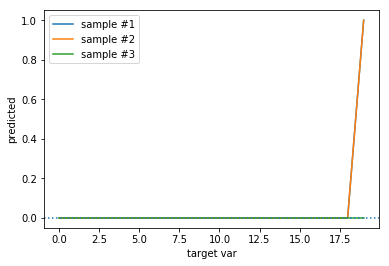

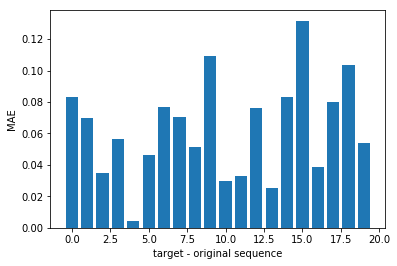

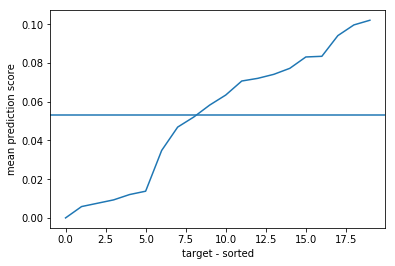

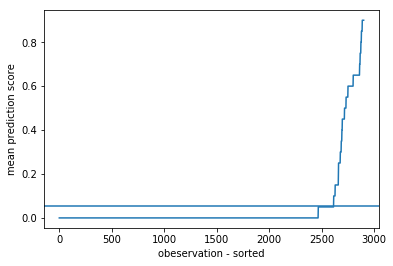

range of prediction :  0.0 1.0


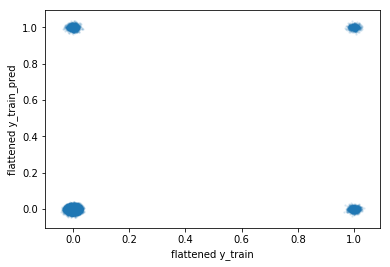


Accuracy: 93.71

Confusion Matrix : 
 [[53470  2195]
 [ 1454   881]]

Recall % :  37.730192719486084


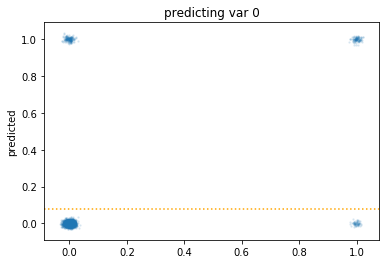

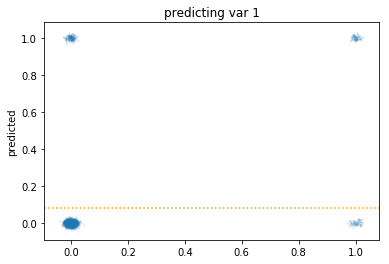

In [91]:
print(history.history.keys())

# "Loss"
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
max_loss = np.max([np.max(history.history['loss']), np.max(history.history['val_loss'])])
plt.ylim(0,max_loss*1.1)
min1pcntloss = np.percentile(history.history['val_loss'],1)
plt.axhline(min1pcntloss, color='grey', linestyle=':')
losstext = 'min 1% val loss : ' + str(round(min1pcntloss,3))
plt.text(60, min1pcntloss+0.05, losstext)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


#--------------

y_train_pred = model.predict(X_train)
print(y_train_pred.shape)

cutoff = 0.08

y_train_f = np.array(y_train).flatten()
y_train_pred_f = np.array(y_train_pred).flatten()
y_train_pred_f = np.where(y_train_pred_f>1, 1, y_train_pred_f)

plt.scatter(rjitt(y_train_f), 
            rjitt(y_train_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_train - before binarization')
plt.ylabel('flattened y_train_pred')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

print('mae = ', abs(y_train_f - y_train_pred_f).mean())
print('corr = ' , np.corrcoef(y_train_f, y_train_pred_f)[0,1])

from sklearn.metrics import r2_score
print('r_sqrd = ', round(r2_score(y_train_f, y_train_pred_f),5))
print('\n')


# check difference in each column
for x in range(nitm):
    y_train_pred[:, x] = np.where(y_train_pred[:, x]<cutoff,0, 1)

print(y_train_pred.mean(axis=0))    

# check sample records
for x in range(3):
    x1 = (23*x) + 10 
    print(x1)
    plt.plot(y_train_pred[x1,:])
plt.legend(['sample #1','sample #2','sample #3'])
plt.axhline(0, linestyle=':')
plt.xlabel('target var')
plt.ylabel('predicted')
plt.show()


# check MAE of each target
mae_list = np.array([]).astype(float)
for x in range(nitm):
    mae_list = np.append(mae_list, round(abs(y_train_pred[:, x] - y_train.ix[:, x]).mean(),4))
plt.bar(list(range(nitm)), mae_list)    
plt.xlabel('target - original sequence')
plt.ylabel('MAE')
plt.show()


plt.plot(np.sort(y_train_pred.mean(axis=0)))
plt.xlabel('target - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_train_pred.mean(axis=0).mean())
plt.show()

plt.plot(np.sort(y_train_pred.mean(axis=1)))
plt.xlabel('obeservation - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_train_pred.mean(axis=1).mean())
plt.show()
print('range of prediction : ', y_train_pred.min(), y_train_pred.max())


y_train_f = np.array(y_train).flatten()
y_train_pred_f = np.array(y_train_pred).flatten()
plt.scatter(rjitt(y_train_f), 
            rjitt(y_train_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_train')
plt.ylabel('flattened y_train_pred')
plt.show()


y_train_predc = np.where(y_train_pred >cutoff, 1, 0)
y_trainc = np.where(y_train >cutoff, 1, 0)


from sklearn.metrics import accuracy_score
# evaluate model :: check accuracy

accuracy = accuracy_score(y_train_f, y_train_pred_f)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(list(y_train_f), list(y_train_pred_f))
print('\nConfusion Matrix : \n', cnf_matrix)
print('\nRecall % : ', (cnf_matrix[1,1])/(cnf_matrix[1].sum())*100)


plt.scatter(rjitt(y_train.ix[:,0]), rjitt(y_train_pred[:,0]),
            s=2, alpha=0.1)
plt.title('predicting var 0')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

plt.scatter(rjitt(y_train.ix[:,1]), rjitt(y_train_pred[:,1]),
            s=2, alpha=0.1)
plt.title('predicting var 1')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()


### Check testset (m+1) performance
- 8월 중의 카테고리별 고객 이용패턴을 예측 결과와 비교 

In [92]:
# Months for test X
tr023 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-05', '2011-06', '2011-07'])]
# Months for test Y
tr024 = tr02[tr02.InvoiceDate.str.slice(0,7).isin(['2011-08'])]

tr11 = tr023[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()
print(tr11.shape)

tr12 = tr11.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr12.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sc']) + np.array(tr12.columns[1:(nitm+1)])
tr12.columns = np.concatenate([np.array(['CustomerID']), sc_list])

tr13 = tr024[['InvoiceNo','CustomerID','StockCode']].groupby(['CustomerID','StockCode']).count().reset_index()

tr14 = tr13.pivot(index='CustomerID', columns='StockCode', values='InvoiceNo').reset_index()
tr14.fillna(0, inplace=True)

# add prefix sc
sc_list = np.char.array(['sct']) + np.array(tr14.columns[1:(nitm+1)])
tr14.columns = np.concatenate([np.array(['CustomerID']), sc_list])
print(tr14.shape)

tr15 = tr12.merge(tr14, on='CustomerID', how='left')
tr15.fillna(0, inplace=True)
tr15.head()

X_test = tr15.ix[:,1:(nitm+1)]
y_test = tr15.ix[:,(nitm+1):((2*nitm)+1)]



(4138, 3)
(641, 21)


In [ ]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의

# for x in range(nitm):
#     y_test.ix[:,x] = np.where(y_test.ix[:,x]>0,1,0)
#     X_test.ix[:,x] = np.where(X_test.ix[:,x]>0,1,0)

In [93]:
# to binarize target :: # 10개 item의 구매여부를 classification 문제 형식으로 정의
# to quantile-based normalize inputs (c.f. YouTube 2016)

from scipy.stats import percentileofscore

for x in range(nitm):
    y_test.ix[:,x] = np.where(y_test.ix[:,x]>0,1,0) # Target
    
    arr_sorted =  sorted(np.array(X_test.ix[:,x].copy()))
    s = X_test.ix[:,x]
    X_test.ix[:,x] = mnmx_scl(s.apply(lambda x: percentileofscore(arr_sorted, x)/100))  # inputs
    

In [94]:
# add super and sub linear derivatives of input features

X_test_supl = X_test.apply(lambda x: x*x)
X_test_supl.columns = np.char.array(['sup']) + np.array(X_test_supl.columns)

X_test_subl = X_test.apply(lambda x: np.sqrt(x))
X_test_subl.columns = np.char.array(['sub']) + np.array(X_test_subl.columns)

X_test = pd.concat([X_test, X_test_supl, X_test_subl], axis=1)
X_test.shape

(1457, 60)

(1457, 20)
(1457, 20) (29140,) (29140,)


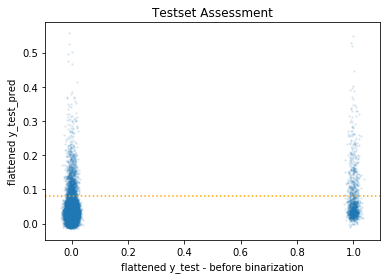

mae =  0.07195708509795073
corr =  0.23723360035014596
r_sqrd =  0.04989


[0.10295127 0.07618394 0.01098147 0.06039808 0.         0.03088538
 0.07755663 0.08304736 0.04941661 0.08647907 0.0082361  0.00549073
 0.05628003 0.00754976 0.08647907 0.10501029 0.00480439 0.09540151
 0.08098833 0.02676733]
10
30
50


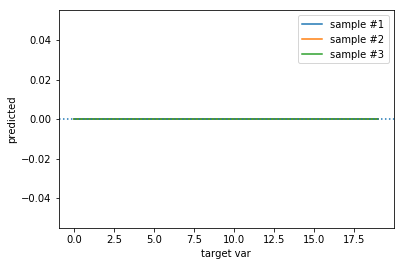

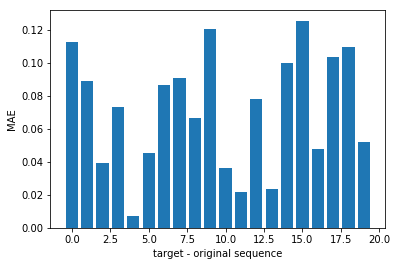

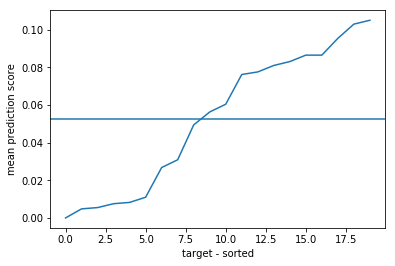

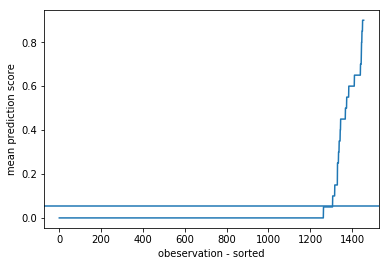

range of prediction :  0.0 1.0


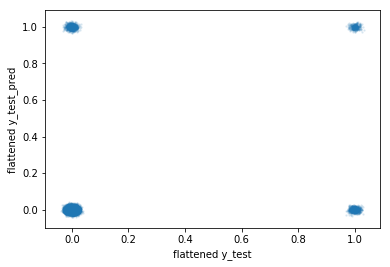


Accuracy: 92.85

Confusion Matrix : 
 [[26713  1194]
 [  890   343]]

Recall % :  27.818329278183292


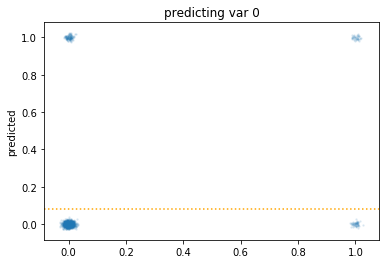

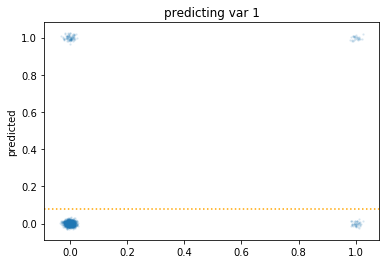

In [95]:
y_test_pred = model.predict(X_test)
print(y_test_pred.shape)

cutoff = 0.08

y_test_f = np.array(y_test).flatten()
y_test_pred_f = np.array(y_test_pred).flatten()
y_test_pred_f = np.where(y_test_pred_f>1, 1, y_test_pred_f)

print(y_test.shape, y_test_f.shape, y_test_pred_f.shape)

plt.scatter(rjitt(y_test_f), 
            rjitt(y_test_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_test - before binarization')
plt.ylabel('flattened y_test_pred')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.title('Testset Assessment')
plt.show()

print('mae = ', abs(y_test_f - y_test_pred_f).mean())
print('corr = ' , np.corrcoef(y_test_f, y_test_pred_f)[0,1])

from sklearn.metrics import r2_score
print('r_sqrd = ', round(r2_score(y_test_f, y_test_pred_f),5))
print('\n')


# check difference in each column
for x in range(nitm):
    y_test_pred[:, x] = np.where(y_test_pred[:, x]<cutoff,0, 1)

print(y_test_pred.mean(axis=0))    

# check sample records
for x in range(3):
    x1 = (20*x) + 10 
    print(x1)
    plt.plot(rjitt(y_test_pred[x1,:]))
plt.legend(['sample #1','sample #2','sample #3'])
plt.axhline(0, linestyle=':')
plt.xlabel('target var')
plt.ylabel('predicted')
plt.show()


# check MAE of each target
mae_list = np.array([]).astype(float)
for x in range(nitm):
    mae_list = np.append(mae_list, round(abs(y_test_pred[:, x] - y_test.ix[:, x]).mean(),4))
plt.bar(list(range(nitm)), mae_list)    
plt.xlabel('target - original sequence')
plt.ylabel('MAE')
plt.show()


plt.plot(np.sort(y_test_pred.mean(axis=0)))
plt.xlabel('target - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_test_pred.mean(axis=0).mean())
plt.show()

plt.plot(np.sort(y_test_pred.mean(axis=1)))
plt.xlabel('obeservation - sorted')
plt.ylabel('mean prediction score')
plt.axhline(y_test_pred.mean(axis=1).mean())
plt.show()
print('range of prediction : ', y_test_pred.min(), y_test_pred.max())


y_test_f = np.array(y_test).flatten()
y_test_pred_f = np.array(y_test_pred).flatten()
plt.scatter(rjitt(y_test_f), 
            rjitt(y_test_pred_f), alpha=0.1, s=2)
plt.xlabel('flattened y_test')
plt.ylabel('flattened y_test_pred')
plt.show()


y_test_predc = np.where(y_test_pred >cutoff, 1, 0)
y_testc = np.where(y_test >cutoff, 1, 0)


from sklearn.metrics import accuracy_score
# evaluate model :: check accuracy

accuracy = accuracy_score(y_test_f, y_test_pred_f)
print('\nAccuracy: %.2f' % (accuracy*100))


# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(list(y_test_f), list(y_test_pred_f))
print('\nConfusion Matrix : \n', cnf_matrix)
print('\nRecall % : ', (cnf_matrix[1,1])/(cnf_matrix[1].sum())*100)


plt.scatter(rjitt(y_test.ix[:,0]), rjitt(y_test_pred[:,0]),
            s=2, alpha=0.1)
plt.title('predicting var 0')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

plt.scatter(rjitt(y_test.ix[:,1]), rjitt(y_test_pred[:,1]),
            s=2, alpha=0.1)
plt.title('predicting var 1')
plt.ylabel('predicted')
plt.axhline(cutoff, color='orange', linestyle=':')
plt.show()

- (batchsize 16, epoch 200) is more accurate than (batchsize 32, epoch 150)
- quantile normalization adds value. Still there seems to be a room to calibrate further
- adding super and sub linear derivative input features seems to work a litte

[Discussion]
- Why not 100% accurate?
- Seasonal difference in item popularity?
- Inpust and targets should be from the same item pool?

## 5.5. Making Recommendations (=Inference)

In [96]:
# randomly select 100 customers from testset 

nsmpls = 300
trtestrun = tr15.sample(n=nsmpls, replace=False)

testrun_smp_idx = trtestrun.index
print(X_test.ix[testrun_smp_idx].shape)
X_test.ix[testrun_smp_idx].head()


(300, 60)


,sc20725,sc20727,sc21212,sc21931,sc22086,sc22197,sc22383,sc22386,sc22411,sc22423,...,subsc22457,subsc22469,subsc22720,subsc22960,subsc23203,subsc47566,subsc84879,subsc85099B,subsc85123A,subscPOST
1117,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.888079,0.859616,0.0,0.000000,0.989089,0.0
1273,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.888079,0.000000,0.0,0.000000,0.000000,0.0
397,0.0,0.837627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
366,0.0,0.837627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.888079,0.859616,0.0,0.894883,0.000000,0.0
463,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.871550,0.0


In [97]:
w, h = nitm, nsmpls

testrecomm_mat = np.array([[None for x in range(w)] for y in range(h)])

testrunX = X_test.ix[testrun_smp_idx]
testrunY = y_test.ix[testrun_smp_idx]

for j in range(len(testrun_smp_idx)):
    X_testrun = testrunX.ix[testrun_smp_idx[j],:]
    # print(X_testrun, X_testrun.shape)
    
    y_test_pred = model.predict(np.array(X_testrun).reshape((-1,60)))
    # print(y_test_pred)

        
    # [ alternatively ] above median probability can be used as the threshold
    # y_test_pred[0] = np.where(y_test_pred[0]>=np.median(y_test_pred[0]), 1, 0)
    # y_test_pred[0] = np.where(y_test_pred[0]>=0.02, 1, 0)
    
    # not to recommend items already purchased during X period
    recomm = y_test_pred[0] - testrunY.ix[testrun_smp_idx[j],:]
    recomm = np.where(recomm <0, 0, recomm)
    
    # 20개 아이템 중 스코어 순 상위 3개만 선정해서 순서대로 추천
    recomm = np.array(recomm).flatten()   
    recomm = [round(d,4) if d >= np.percentile(recomm,85) and d>0 else 0 for d in recomm]
    print('recomm for test cust ', j ,' : ' , recomm )
    testrecomm_mat[j,:] = recomm
    

recomm for test cust  0  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  1  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  2  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  3  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  4  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  5  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  6  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  7  :  [0, 0, 0, 0, 0, 0, 0.1453, 0, 0, 0, 0, 0, 0, 0, 0.1673, 0.176, 0, 0, 0, 0]
recomm for test cust  8  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  9  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0541, 0

recomm for test cust  98  :  [0, 0, 0, 0, 0, 0, 0, 0.0364, 0, 0, 0, 0, 0, 0, 0.0343, 0.0543, 0, 0, 0, 0]
recomm for test cust  99  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0527, 0, 0, 0, 0, 0, 0.0412, 0, 0, 0, 0.1042]
recomm for test cust  100  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  101  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  102  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  103  :  [0.0693, 0, 0, 0, 0, 0, 0, 0, 0, 0.0714, 0, 0, 0, 0, 0, 0.0775, 0, 0, 0, 0]
recomm for test cust  104  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  105  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0555, 0, 0, 0, 0, 0, 0.049, 0, 0, 0, 0.0649]
recomm for test cust  106  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  107  :  [0, 0, 0, 0, 0, 0, 

recomm for test cust  193  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0545, 0, 0, 0, 0, 0, 0.046, 0, 0.0318, 0, 0]
recomm for test cust  194  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  195  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  196  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  197  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  198  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  199  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  200  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  201  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  202  :  [0, 0, 0, 0, 0, 0

recomm for test cust  284  :  [0, 0, 0, 0, 0, 0, 0, 0.0364, 0, 0.0609, 0, 0, 0, 0, 0.0343, 0, 0, 0, 0, 0]
recomm for test cust  285  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  286  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  287  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  288  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  289  :  [0.4646, 0, 0, 0, 0, 0, 0.2737, 0, 0, 0, 0, 0, 0, 0, 0.3169, 0, 0, 0, 0, 0]
recomm for test cust  290  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  291  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  292  :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0609, 0, 0, 0, 0, 0, 0.0543, 0, 0, 0.0435, 0]
recomm for test cust  293  :  [0, 0, 0, 0, 0, 

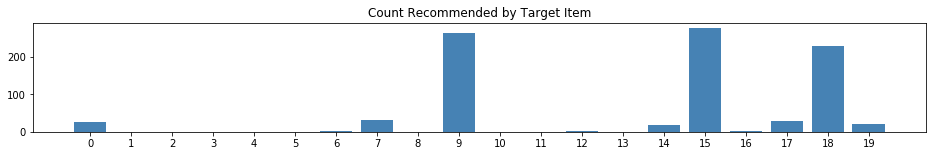

Total Count Recommended :  900.0 ( 100.0 %)


In [98]:
means = np.array([])
for x in range(nitm):
    tmp_cnt = np.array([1 if y >0 else y for y in testrecomm_mat[:,x]])
    means = np.append(means, tmp_cnt.sum())

plt.figure(figsize=(16,2))
var_labels = np.array(range(nitm)).astype(str)
plt.bar(var_labels, means, color='steelblue')
plt.title('Count Recommended by Target Item')
plt.show()

# 3건 모두 추천이 이루어진 건의 수와 비율 확인
print('Total Count Recommended : ', means.sum(), '(', round(means.sum()/(h*3)*100,2), '%)')

- 기준을 만족하는 제안건이 3건이 되지 않는 경우도 발생 가능
- 무조건 3건을 채우기로 한 경우라면 이를 위한 추가적인 장치 (e.g. random, simple logic) 마련 필요 
- 보다 popular한 item 혹은 특정 item으로 추천이 집중되는 쏠림 현상 보임 (참고: 일부는 이미 구매한 상품을 제외한 영향)
- Score 자체를 그대로 사용하는 대신 추천 분산을 유도하는 로직 적용 필요

- recsys 2019 paper on YouTube explained :  https://towardsdatascience.com/how-youtube-recommends-videos-b6e003a5ab2f 